In [90]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from shapely.ops import transform
import matplotlib.patches as patches
from shapely.geometry import Polygon, box, mapping
from shapely.ops import unary_union
from pyproj import Transformer, CRS
import numpy as np
from typing import List, Tuple

from shapely.affinity import rotate

import plotly.graph_objects as go


In [91]:
def extract_polygons_from_kml(path):
    tree = ET.parse(path)
    root = tree.getroot()

    # KML namespace
    ns = {'kml': 'http://www.opengis.net/kml/2.2'}

    polygons = []

    # Find ALL <coordinates> inside ANY <Polygon>
    for coords in root.findall(".//kml:Polygon//kml:coordinates", ns):
        text = coords.text.strip()
        pts = []

        for line in text.split():
            lon, lat, *_ = line.split(',')
            pts.append((float(lon), float(lat)))

        polygons.append(pts)

    return polygons


In [92]:
polygons = extract_polygons_from_kml("valid.kml")
print("Found polygons:", len(polygons))

for p in polygons:
    print(p[:3], "...")


Found polygons: 10
[(-122.0848938459612, 37.42257124044786), (-122.0849580979198, 37.42211922626856), (-122.0847469573047, 37.42207183952619)] ...
[(-122.0857412771483, 37.42227033155257), (-122.0858169768481, 37.42231408832346), (-122.085852582875, 37.42230337469744)] ...
[(-122.0857862287242, 37.42136208886969), (-122.0857312990603, 37.42136935989481), (-122.0857312992918, 37.42140934910903)] ...
[(-122.0844371128284, 37.42177253003091), (-122.0845118855746, 37.42191111542896), (-122.0850470999805, 37.42178755121535)] ...
[(-77.05788457660967, 38.87253259892824), (-77.05465973756702, 38.87291016281703), (-77.0531553685479, 38.87053267794386)] ...
[(-77.05668055019126, 38.87154239798456), (-77.05542625960818, 38.87167890344077), (-77.05485125901023, 38.87076535397792)] ...
[(-112.3372510731295, 36.14888505105317), (-112.3356128688403, 36.14781540589019), (-112.3368169371048, 36.14658677734382)] ...
[(-112.3396586818843, 36.14637618647505), (-112.3380597654315, 36.14531751871353), (-11

The generate_offsets will round off after $10^{-6}$

In [93]:
def generate_offsets(rect_w = 1, rect_h = 1, w_res = 10, h_res = 10, mode = "land"):
    if mode == "rect":
        step_w = rect_w / w_res
        step_h = rect_h / h_res
    elif mode == "land":
        step_w = 1 / w_res
        step_h = 1 / h_res
    else:
        raise ValueError("Mode not selected")

    offsets = []
    for i in range(w_res):
        for j in range(h_res):
            offsets.append((
                round(i * step_w, 6),
                round(j * step_h, 6)
            ))
    return offsets

In [94]:
generate_offsets(w_res = 5, h_res = 10, mode = "land")

[(0.0, 0.0),
 (0.0, 0.1),
 (0.0, 0.2),
 (0.0, 0.3),
 (0.0, 0.4),
 (0.0, 0.5),
 (0.0, 0.6),
 (0.0, 0.7),
 (0.0, 0.8),
 (0.0, 0.9),
 (0.2, 0.0),
 (0.2, 0.1),
 (0.2, 0.2),
 (0.2, 0.3),
 (0.2, 0.4),
 (0.2, 0.5),
 (0.2, 0.6),
 (0.2, 0.7),
 (0.2, 0.8),
 (0.2, 0.9),
 (0.4, 0.0),
 (0.4, 0.1),
 (0.4, 0.2),
 (0.4, 0.3),
 (0.4, 0.4),
 (0.4, 0.5),
 (0.4, 0.6),
 (0.4, 0.7),
 (0.4, 0.8),
 (0.4, 0.9),
 (0.6, 0.0),
 (0.6, 0.1),
 (0.6, 0.2),
 (0.6, 0.3),
 (0.6, 0.4),
 (0.6, 0.5),
 (0.6, 0.6),
 (0.6, 0.7),
 (0.6, 0.8),
 (0.6, 0.9),
 (0.8, 0.0),
 (0.8, 0.1),
 (0.8, 0.2),
 (0.8, 0.3),
 (0.8, 0.4),
 (0.8, 0.5),
 (0.8, 0.6),
 (0.8, 0.7),
 (0.8, 0.8),
 (0.8, 0.9)]

# Without Rotation

In [95]:
def pack_rectangles_in_polygon(polygon_lonlat, rect_w_m, rect_h_m, try_offsets, resolution):
    """
    Pack identical axis-aligned rectangles (orientation = 0) inside a single polygon (lon,lat).
    Returns a list of rectangles as tuples (lon_min, lat_min, lon_max, lat_max).
    
    Args:
        polygon_lonlat: list of (lon, lat) coordinates forming a polygon (closed or not; function will close it).
        rect_w_m: rectangle width in meters.
        rect_h_m: rectangle height in meters.
        try_offsets: if True, try grid offsets (0 and half-cell) in x/y and choose best.
        
    Notes:
        - Uses a local Azimuthal Equidistant projection centered on polygon centroid to reduce distortion.
        - The algorithm tests full containment: a rectangle is accepted only if polygon.contains(rectangle).
    """
    # --- Build shapely polygon from lon/lat input ---
    poly_ll = Polygon(polygon_lonlat)
    if not poly_ll.is_valid:
        poly_ll = poly_ll.buffer(0)
    if poly_ll.is_empty:
        return []
    
    # --- Choose local projection: Azimuthal Equidistant centered on polygon centroid ---
    centroid = poly_ll.centroid
    center_lon, center_lat = centroid.x, centroid.y
    # Build pyproj transformers
    aeq_crs = CRS.from_proj4(f"+proj=aeqd +lat_0={center_lat} +lon_0={center_lon} +units=m +datum=WGS84 +no_defs")
    wgs84 = CRS.from_epsg(4326)
    to_local = Transformer.from_crs(wgs84, aeq_crs, always_xy=True).transform
    to_wgs84 = Transformer.from_crs(aeq_crs, wgs84, always_xy=True).transform
    
    # --- Project polygon to local meters plane ---
    poly_coords_local = [to_local(lon, lat) for lon, lat in polygon_lonlat]
    poly_local = Polygon(poly_coords_local)
    if not poly_local.is_valid:
        poly_local = poly_local.buffer(0)
    if poly_local.is_empty:
        return []
    
    # --- Bounding box in local coords ---
    minx, miny, maxx, maxy = poly_local.bounds
    
    # --- Candidate offsets to try (improves packing density) ---
    if try_offsets == True:
        offsets = generate_offsets(rect_w_m, rect_h_m, resolution)
    elif try_offsets == "half":
        offsets = [
            (0.0, 0.0),
            (rect_w_m / 2.0, 0.0),
            (0.0, rect_h_m / 2.0),
            (rect_w_m / 2.0, rect_h_m / 2.0),
        ]
    else:
        offsets = [(0.0, 0.0)]
    
    best_rects_local = []
    best_count = -1
    
    # --- For each offset, sweep the grid and test containment ---
    for ox, oy in offsets:
        # start positions (ensure we cover the entire bbox)
        start_x = minx - (rect_w_m + 1)  # small margin so offsetting works when bbox aligns to grid
        start_y = miny - (rect_h_m + 1)
        # compute grid ranges (use numpy arange for clarity)
        xs = np.arange(start_x + ox, maxx + rect_w_m, rect_w_m)
        ys = np.arange(start_y + oy, maxy + rect_h_m, rect_h_m)
        
        rects = []
        for x in xs:
            # quick skip if x > maxx: loop will break naturally due to arange limit
            for y in ys:
                # rectangle bottom-left (x, y) to top-right (x+rect_w_m, y+rect_h_m)
                candidate = box(x, y, x + rect_w_m, y + rect_h_m)
                # Full containment test
                if poly_local.contains(candidate):
                    rects.append(candidate)
        
        if len(rects) > best_count:
            best_count = len(rects)
            best_rects_local = rects
    
    # --- Convert best rectangles back to lon/lat and return as lon_min, lat_min, lon_max, lat_max ---
    result = []
    for r in best_rects_local:
        x1, y1, x2, y2 = r.bounds
        lon1, lat1 = to_wgs84(x1, y1)
        lon2, lat2 = to_wgs84(x2, y2)
        result.append((lon1, lat1, lon2, lat2))
    
    return result, best_count

# Example usage:
# polygons = [...]  # list of (lon,lat) for one polygon
# rects = pack_rectangles_in_polygon(polygons[0], rect_w_m=2.0, rect_h_m=1.0)
# returns list of rectangle lon/lat bounds


In [96]:
def plot_polygon_without_rectangles(polygon_lonlat, rects_lonlat):
    # Build polygon
    poly = Polygon(polygon_lonlat)

    fig, ax = plt.subplots(figsize=(8,8))

    # Plot polygon
    x, y = poly.exterior.xy
    ax.plot(x, y, color="black", linewidth=2)
    ax.fill(x, y, alpha=0.2, color="gray")


    ax.set_aspect("equal", adjustable="box")
    plt.show()

In [97]:
def plot_polygon_with_rectangles(polygon_lonlat, rects_lonlat):
    # Build polygon
    poly = Polygon(polygon_lonlat)

    fig, ax = plt.subplots(figsize=(8,8))

    # Plot polygon
    x, y = poly.exterior.xy
    ax.plot(x, y, color="black", linewidth=2)
    ax.fill(x, y, alpha=0.2, color="gray")

    # Plot rectangles
    for (lon1, lat1, lon2, lat2) in rects_lonlat:
        w = lon2 - lon1
        h = lat2 - lat1
        rect = patches.Rectangle(
            (lon1, lat1),
            w,
            h,
            linewidth=0.5,
            edgecolor="blue",
            facecolor="none"
        )
        ax.add_patch(rect)

    ax.set_aspect("equal", adjustable="box")
    plt.show()

In [98]:
current_polygon = polygons[1]
width = 10
height = 5
res = 50

In [99]:
rect_coords, max_ = pack_rectangles_in_polygon(polygon_lonlat = current_polygon, rect_w_m = width, rect_h_m = height, try_offsets = True, resolution=res)

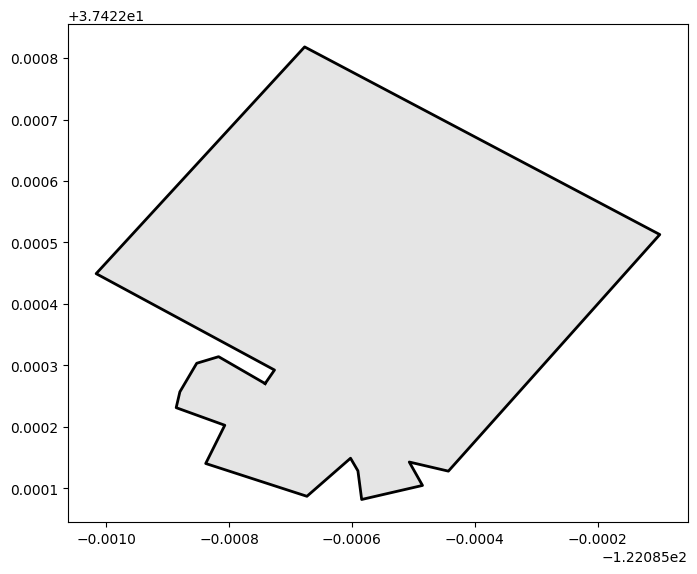

In [100]:
plot_polygon_without_rectangles(current_polygon, rect_coords)

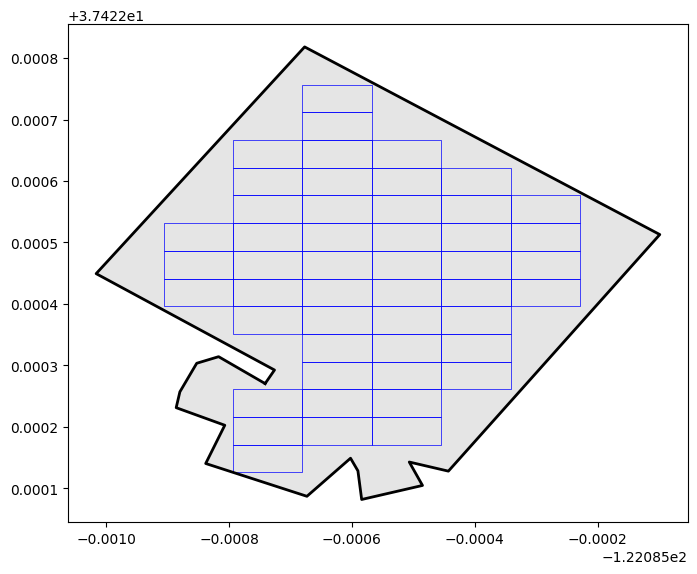

In [101]:
plot_polygon_with_rectangles(current_polygon, rect_coords)


In [102]:
max_

49

# Implementing Rotation

In [51]:
def pack_rectangles_in_polygon_rot(polygon_lonlat, rect_w_m, rect_h_m, try_offsets, resolution, angle_deg):
    poly_ll = Polygon(polygon_lonlat)
    if not poly_ll.is_valid:
        poly_ll = poly_ll.buffer(0)
    if poly_ll.is_empty:
        return []

    centroid = poly_ll.centroid
    center_lon, center_lat = centroid.x, centroid.y
    aeq_crs = CRS.from_proj4(f"+proj=aeqd +lat_0={center_lat} +lon_0={center_lon} +units=m +datum=WGS84 +no_defs")
    wgs84 = CRS.from_epsg(4326)
    to_local = Transformer.from_crs(wgs84, aeq_crs, always_xy=True).transform
    to_wgs84 = Transformer.from_crs(aeq_crs, wgs84, always_xy=True).transform

    poly_coords_local = [to_local(lon, lat) for lon, lat in polygon_lonlat]
    poly_local = Polygon(poly_coords_local)
    if not poly_local.is_valid:
        poly_local = poly_local.buffer(0)
    if poly_local.is_empty:
        return []

    rot_origin = poly_local.centroid

    poly_rot = rotate(poly_local, -angle_deg, origin=rot_origin, use_radians=False)
    minx, miny, maxx, maxy = poly_rot.bounds

    if try_offsets == True:
        offsets = generate_offsets(rect_w_m, rect_h_m, resolution)
    elif try_offsets == "half":
        offsets = [
            (0.0, 0.0),
            (rect_w_m / 2.0, 0.0),
            (0.0, rect_h_m / 2.0),
            (rect_w_m / 2.0, rect_h_m / 2.0),
        ]
    else:
        offsets = [(0.0, 0.0)]

    best_rects = []
    best_count = -1

    for ox, oy in offsets:
        start_x = minx - (rect_w_m + 1)
        start_y = miny - (rect_h_m + 1)
        xs = np.arange(start_x + ox, maxx + rect_w_m, rect_w_m)
        ys = np.arange(start_y + oy, maxy + rect_h_m, rect_h_m)

        rects = []
        for x in xs:
            for y in ys:
                candidate = box(x, y, x + rect_w_m, y + rect_h_m)
                if poly_rot.contains(candidate):
                    rects.append(candidate)

        if len(rects) > best_count:
            best_count = len(rects)
            best_rects = rects

    result = []
    for r in best_rects:
        r_back = rotate(r, angle_deg, origin=rot_origin, use_radians=False)
        coords = list(r_back.exterior.coords)[:-1]
        coords_lonlat = [to_wgs84(x, y) for x, y in coords]
        result.append(coords_lonlat)

    return result, best_count, best_rects, poly_rot



In [83]:
current_polygon = polygons[0]
width = 20
height = 10
res = 50
angle = 60

In [84]:
a, b, c, poly_local = pack_rectangles_in_polygon_rot(
    polygon_lonlat = current_polygon,
    rect_w_m = width,
    rect_h_m = height,
    try_offsets = True,
    resolution = res,
    angle_deg = angle
)

## MatPlotLib

In [85]:
def add_north_arrow(ax, size=0.1):
    ax.annotate(
        'N',
        xy=(0.05, 0.95),               # arrow tip (top of arrow)
        xytext=(0.05, 0.95 - size),    # arrow tail
        xycoords='axes fraction',
        textcoords='axes fraction',
        ha='center',
        va='center',
        fontsize=12,
        arrowprops=dict(facecolor='black', width=4, headwidth=12)
    )

In [86]:
def plot_polygon_with_rectangles_local(poly_local, rects_local, max_count):
    fig, ax = plt.subplots(figsize=(12,4))

    x, y = poly_local.exterior.xy
    ax.plot(x, y, color="black", linewidth=2)
    ax.fill(x, y, alpha=0.2, color="gray")

    for r in rects_local:
        rx, ry = r.exterior.xy
        ax.plot(rx, ry, color="blue", linewidth=0.7)

    ax.text(
        0.98, 0.98,
        f"Max count: {max_count}",
        transform=ax.transAxes,
        ha="right",
        va="top",
        fontsize=12,
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="none")
    )

    # add north arrow (size controls arrow length)
    add_north_arrow(ax, size=0.12)

    ax.set_aspect("equal", adjustable="box")
    plt.show()


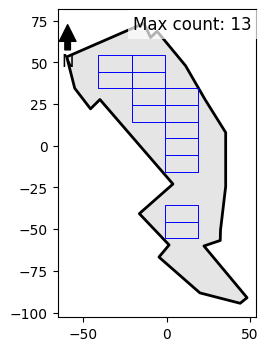

In [87]:

plot_polygon_with_rectangles_local(poly_local, c, b)
